# Imports

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
import re
import matplotlib.pyplot as plt
import seaborn as sns

# loading data
-The main dataset was loaded as a pandas dataframe.
-New data was concatenated with the main dataset for easier processing.

In [10]:
df = pd.read_csv('03 customer_churn.csv')

# Load the new data
new_data = pd.read_csv('03 new_customers.csv')

# Convert 'Onboard_date' column to datetime type
new_data['Onboard_date'] = pd.to_datetime(new_data['Onboard_date'])

# Concatenate the new data with the dataset
df = pd.concat([df, new_data], ignore_index=True)


In [11]:
print(df.head())
print(df.tail())

              Names   Age  Total_Purchase  Account_Manager  Years  Num_Sites  \
0  Cameron Williams  42.0        11066.80                0   7.22        8.0   
1     Kevin Mueller  41.0        11916.22                0   6.50       11.0   
2       Eric Lozano  38.0        12884.75                0   6.67       12.0   
3     Phillip White  42.0         8010.76                0   6.71       10.0   
4    Cynthia Norton  37.0         9191.58                0   5.56        9.0   

          Onboard_date                                           Location  \
0  2013-08-30 07:00:40      10265 Elizabeth Mission Barkerburgh, AK 89518   
1  2013-08-13 00:38:46  6157 Frank Gardens Suite 019 Carloshaven, RI 1...   
2  2016-06-29 06:20:07             1331 Keith Court Alyssahaven, DE 90114   
3  2014-04-22 12:43:12       13120 Daniel Mount Angelabury, WY 30645-4695   
4  2016-01-19 15:31:15                765 Tricia Row Karenshire, MH 71730   

                       Company  Churn  
0               

# Data Preprocessing

In [12]:
# Check for null values
null_values = df.isnull().sum()
print("Null Values:")
print(null_values)

Null Values:
Names              0
Age                0
Total_Purchase     0
Account_Manager    0
Years              0
Num_Sites          0
Onboard_date       0
Location           0
Company            0
Churn              6
dtype: int64


# Feature engineering

datetime64[ns]


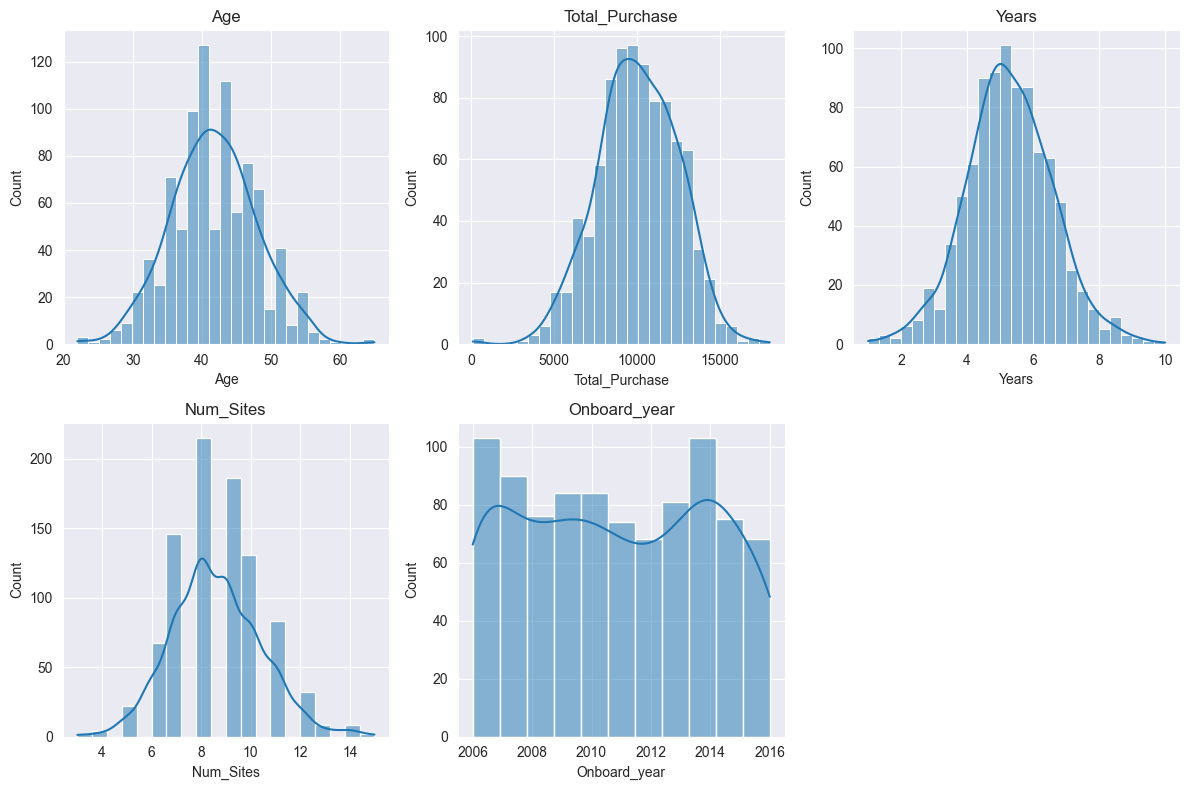

Number of distinct State Codes: 62
Number of distinct companies: 879


In [13]:
# Convert 'Onboard_date' column to datetime type
df['Onboard_date'] = pd.to_datetime(df['Onboard_date'])

# Verify the data type of the 'Onboard_date' column after conversion
print(df['Onboard_date'].dtype)

# Extract year from 'Onboard_date'
df['Onboard_year'] = df['Onboard_date'].dt.year

# Drop the original 'Onboard_date' column
df.drop('Onboard_date', axis=1, inplace=True)

# Reorder the columns
df = df[['Names', 'Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites', 'Location', 'Company', 'Onboard_year', 'Churn']]

# Density Plots to show feature spread
numeric_cols = ['Age', 'Total_Purchase', 'Years', 'Num_Sites', 'Onboard_year']
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

# Scaling numeric features
scaler = StandardScaler()
numeric_cols = ['Age', 'Total_Purchase', 'Years', 'Num_Sites', 'Onboard_year']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Function to extract state code from 'location' column
def extract_state(location):
    state_code = re.search(r'\b([A-Z]{2})\b', location)
    if state_code:
        return state_code.group(1)
    else:
        return None  # Return None if no state code found

# Apply the function to the entire 'Location' column and replace it
df['Location'] = df['Location'].apply(extract_state)

# Rename the column to 'State_Code'
df = df.rename(columns={'Location': 'State_Code'})

# Count the number of distinct State Codes
num_unique_State_Code = df['State_Code'].nunique()

print("Number of distinct State Codes:", num_unique_State_Code)

# Apply one-hot encoding to the 'State_Code' column
df = pd.get_dummies(df, columns=['State_Code'], prefix='State')

# Count the number of distinct companies in the 'Company' column
num_unique_companies = df['Company'].nunique()

print("Number of distinct companies:", num_unique_companies)


## Findings based on the preprocessing of the dataset

1. No null values were found.
2. The values in the 'location' column were unique to each customer and so it had no effect on the label data. However, there are 62 unique state codes in the location data making it more useful for analysis.
3. The new 'state_code' feature was converted to numeric values using one-hot encoding.
4. The values in the 'Company' column were almost unique to each customer as 873 distinct entries were found in that column and since there was no useful data to extract from that column, it was discarded.
5. The 'onboard_year' was extracted from the 'onboard_date' feature.
6. All numeric features were scaled using standard scaler.
7. Scaling the features helped the model converge in under 100 iterations compared to over 1000 before scaling.

## Separating the new data from the original dataset after processing

In [14]:
# Get the last 6 rows of the dataset
new_data = df.tail(6)

# Remove the last 6 rows from the original dataset
df = df.iloc[:-6]

# Print to verify
print(f"New Data: {new_data}")


New Data:               Names       Age  Total_Purchase  Account_Manager     Years  \
900   Andrew Mccall -0.765108       -0.045708                1  1.859491   
901  Michele Wright -3.009471       -1.037254                1  3.062535   
902    Jeremy Chang  3.723618       -4.094708                1 -3.282182   
903  Megan Ferguson -1.566666       -1.465161                0  3.154487   
904    Taylor Young -1.566666        1.276652                1  3.614249   
905   Jessica Drake -3.169782       -0.659209                1 -1.397157   

     Num_Sites           Company  Onboard_year  Churn  State_AA  ...  \
900  -0.340001          King Ltd      0.060620    NaN     False  ...   
901   3.545199     Cannon-Benson      0.684734    NaN     False  ...   
902   3.545199  Barron-Robertson     -1.499664    NaN     False  ...   
903   2.990171     Sexton-Golden      1.620904    NaN     False  ...   
904  -0.340001          Wood LLC      0.372677    NaN     False  ...   
905   2.990171     Parks-

# Logistic Regression

Cross-validation scores: [0.87777778 0.89444444 0.87777778 0.88888889 0.91111111]
Mean accuracy: 0.89


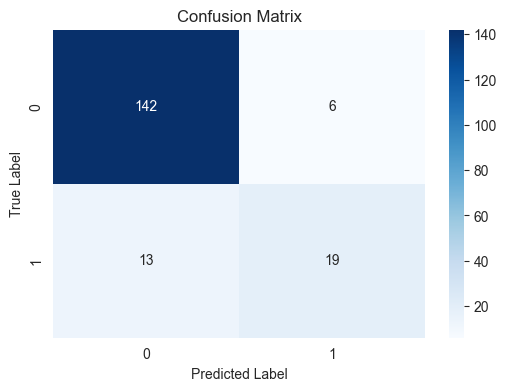

Accuracy: 0.8944444444444445

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.96      0.94       148
         1.0       0.76      0.59      0.67        32

    accuracy                           0.89       180
   macro avg       0.84      0.78      0.80       180
weighted avg       0.89      0.89      0.89       180



In [15]:
# Splitting the data into features and target variable
X = df.drop(['Names', 'Company', 'Churn'], axis=1)  # Features
y = df['Churn']  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

# Confusion Matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


# Predicting churn for new data

In [16]:
prediction = model.predict(new_data.drop(['Names', 'Company', 'Churn'], axis=1))
print(prediction)

[0. 1. 1. 1. 0. 1.]
